In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
from scipy import stats

import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence, select_months, create_list_all_dates
from teleconnections import build_teleconnection_df
from statistical_tests import build_zscore_df, ttest_1samp_new

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures

# USE pandas.options TO DISPLAY FLOATS TO TWO DECIMAL PLACES
pd.options.display.float_format = "{:,.2f}".format

In [3]:
start_date = '1979-03-01'
end_date = '2018-05-31'

tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
tele

,AO,PDO,ENSO,SH
date,,,,
1979-03-01 09:00:00,1,-1,0,-1
1979-03-02 09:00:00,1,-1,0,-1
1979-03-03 09:00:00,1,-1,0,-1
1979-03-04 09:00:00,1,-1,0,-1
1979-03-05 09:00:00,1,-1,0,-1
...,...,...,...,...
2018-05-27 09:00:00,1,-1,0,1
2018-05-28 09:00:00,1,-1,0,1
2018-05-29 09:00:00,1,-1,0,1


In [4]:
df_index_djf = select_months(tele, 12, 2)
df_index_mam = select_months(tele, 3, 5)
df_index_djfmam = select_months(tele, 12, 5)
print('# DJF days: ', len(df_index_djf))
print('# MAM days: ', len(df_index_mam))
print('# DJFMAM days: ', len(df_index_djfmam))

# DJF days:  3520
# MAM days:  3680
# DJFMAM days:  7200


In [5]:
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

In [6]:
def ar_daily_df(ssn, nk):
    out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
    filepath = out_path + 'AR-types_ALLDAYS.csv'
    df = pd.read_csv(filepath)

    # set up datetime index
    df = df.rename(columns={'Unnamed: 0': 'date'})
    df = df.set_index(pd.to_datetime(df.date))
    
    ## Break up columns into different AR Types
    keys = []
    for k in range(nk):
        keys.append("AR_CAT{:1d}".format(k+1,))

    values = np.zeros((len(df.index)))
    dicts = dict(zip(keys, values))

    df_cat = pd.DataFrame(dicts, index=df.index)

    for k in range(nk):
        idx = (df['AR_CAT'] == k+1)
        col = "AR_CAT{:1d}".format(k+1,)
        df_cat.loc[idx, col] = 1
        
    # get total of all AR types
    df_cat['AR_ALL'] = df_cat['AR_CAT1'] + df_cat['AR_CAT2'] + df_cat['AR_CAT3']
    df_cat['AR_CAT'] = df['AR_CAT']
    
    return df_cat

In [7]:
df_djf = ar_daily_df(ssn='djf', nk=3)
df_mam = ar_daily_df(ssn='mam', nk=3)
df_djfmam = ar_daily_df(ssn='djfmam', nk=3)

In [8]:
# combine ar df with tele df
print(len(df_djf), len(df_index_djf), len(df_mam), len(df_index_mam))
# join indices with AR count
new_djf = df_djf.join(df_index_djf)
new_mam = df_mam.join(df_index_mam)
new_djfmam = df_djfmam.join(df_index_djfmam)

3520 3520 3680 3680


### Run zscore difference in proportion tests

In [9]:
zscore_djf = build_zscore_df(new_djf)
zscore_djf

zstat  pval
Teleconnection AR Type             
AO             AR_CAT1   2.71  0.01
               AR_CAT2  -1.08  0.28
               AR_CAT3   3.66  0.00
               AR_ALL    3.46  0.00
PDO            AR_CAT1  -2.11  0.03
               AR_CAT2   0.64  0.52
               AR_CAT3   0.40  0.69
               AR_ALL   -0.50  0.62
ENSO           AR_CAT1  -0.55  0.58
               AR_CAT2   1.75  0.08
               AR_CAT3   3.39  0.00
               AR_ALL    3.06  0.00
SH             AR_CAT1   0.31  0.76
               AR_CAT2  -0.10  0.92
               AR_CAT3  -1.45  0.15
               AR_ALL   -0.92  0.36

In [10]:
zscore_mam = build_zscore_df(new_mam)
zscore_mam

zstat  pval
Teleconnection AR Type             
AO             AR_CAT1   4.48  0.00
               AR_CAT2  -1.43  0.15
               AR_CAT3  -1.43  0.15
               AR_ALL    0.96  0.33
PDO            AR_CAT1   3.85  0.00
               AR_CAT2   2.01  0.04
               AR_CAT3   2.05  0.04
               AR_ALL    4.74  0.00
ENSO           AR_CAT1   3.95  0.00
               AR_CAT2   1.80  0.07
               AR_CAT3   0.64  0.52
               AR_ALL    3.78  0.00
SH             AR_CAT1  -4.04  0.00
               AR_CAT2   2.25  0.02
               AR_CAT3  -1.17  0.24
               AR_ALL   -1.76  0.08

In [11]:
zscore_djfmam = build_zscore_df(new_djfmam)
zscore_djfmam

zstat  pval
Teleconnection AR Type             
AO             AR_CAT1  -1.11  0.27
               AR_CAT2   5.84  0.00
               AR_CAT3   0.06  0.95
               AR_ALL    3.02  0.00
PDO            AR_CAT1   1.86  0.06
               AR_CAT2   2.65  0.01
               AR_CAT3   0.36  0.72
               AR_ALL    2.98  0.00
ENSO           AR_CAT1   1.39  0.16
               AR_CAT2   5.38  0.00
               AR_CAT3   1.00  0.32
               AR_ALL    4.76  0.00
SH             AR_CAT1  -0.19  0.85
               AR_CAT2  -3.83  0.00
               AR_CAT3   0.94  0.35
               AR_ALL   -1.98  0.05

### Bar Plot Fractions

In [12]:
cols = ['AR_CAT1', 'AR_CAT2', 'AR_CAT3', 'AR_ALL']
djf = new_djf.drop(columns=cols)
mam = new_mam.drop(columns=cols)
djf

,AR_CAT,AO,PDO,ENSO,SH
date,,,,,
1979-12-01 09:00:00,3,1,1,0,1
1979-12-02 09:00:00,3,1,1,0,1
1979-12-03 09:00:00,0,1,1,0,1
1979-12-04 09:00:00,0,1,1,0,1
1979-12-05 09:00:00,0,1,1,0,1
...,...,...,...,...,...
2018-02-24 09:00:00,0,-1,-1,-1,1
2018-02-25 09:00:00,0,-1,-1,-1,1
2018-02-26 09:00:00,2,-1,-1,-1,1


In [13]:
results_test = []
for i, df in enumerate([djf, mam]):
    test_df = df
    # count the frequency of each AR type based on phase conditions
    test = test_df.groupby(['AR_CAT']).agg({'AO': 'value_counts',
                                        'PDO': 'value_counts',
                                        'ENSO': 'value_counts',
                                        'SH': 'value_counts'})
    # get the frequency value
    test2 = test.div(len(test_df)) * 100

    # put into a new dataframe and reset the index
    data=pd.DataFrame(test2)
    data = data.reset_index()

    # melt the dataframe to make it tidy
    results = pd.melt(data, id_vars=['level_0', 'level_1'], value_vars=['AO', 'PDO', 'ENSO', 'SH'],
                      var_name='teleconnection', value_name='frequency')

    # drop rows where level_0 = 0
    # or where there is no AR
    results_test.append(results[results.level_0 != 0])

In [14]:
# put into a new dataframe and reset the index
mamdata=pd.DataFrame(zscore_mam)
mamdata = mamdata.reset_index()

djfdata=pd.DataFrame(zscore_djf)
djfdata = djfdata.reset_index()

data = [djfdata, mamdata]

/home/nash/DATA/repositories/AR_types/figs/zscore_barplot.png


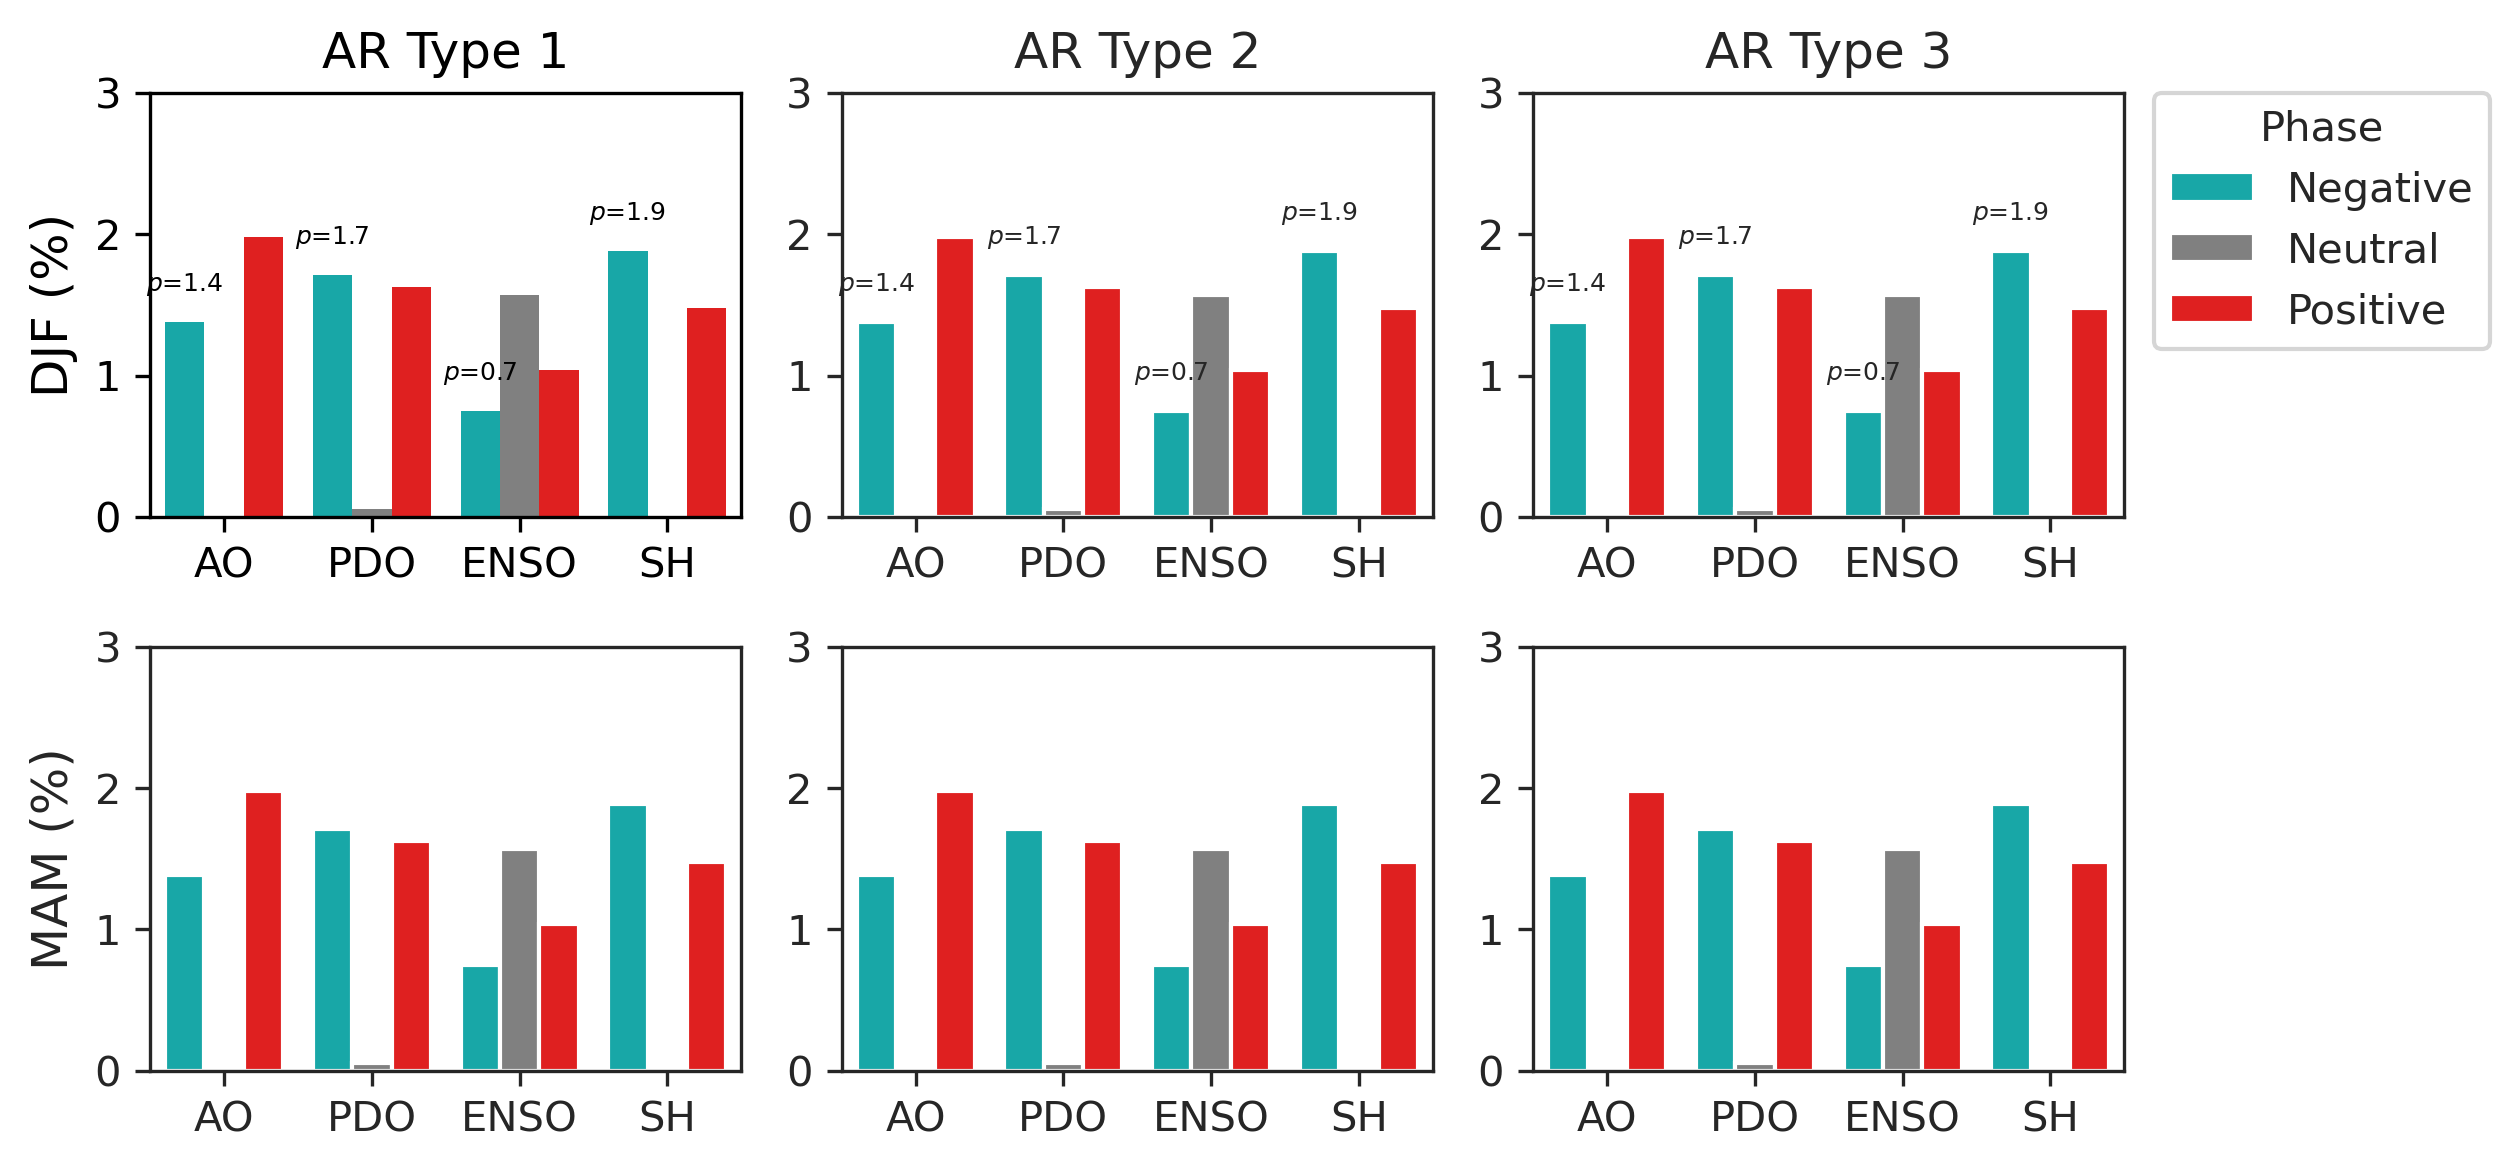

<Figure size 2550x1200 with 0 Axes>

In [15]:
# TO DO: add pvalues to x-axis labels
fname = path_to_figs + 'zscore_barplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.5,4.0))
fig.dpi = 300
nrows = 2
ncols = 3
nplots=nrows*ncols

artype = [1, 2, 3]
typ_label = ['AR Type 1', 'AR Type 2', 'AR Type 3']
flatui = ['c', 'grey', 'red', ]
ssn_lst = ['DJF', 'MAM']
row_lbl1 = ['DJF (%)', '', '']
row_lbl2 = ['MAM (%)', '', '']

#### DJF Plots
for i, (p, ar) in enumerate(zip(np.arange(0, 3), artype)):
    data = results_test[0]
    ax = plt.subplot(nrows, ncols, p+1)
    df = data[data.level_0 == ar]
    g = sns.barplot(x=data['teleconnection'], y=data['frequency'], hue=data["level_1"],
                data=df, palette=flatui, dodge=True, ci=None)
    for p in g.patches[:4]:
        g.annotate("$p$=" + format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center',
                   size=6,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel(row_lbl1[i], fontsize=12)
    ax.set_xlabel('')
    plt.ylim(0, 3)
    ax.set_title(typ_label[i], loc='center')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=['Negative', 'Neutral', 'Positive'], title='Phase')
    
### MAM Plots
for i, (p, ar) in enumerate(zip(np.arange(3, 6), artype)):
    data = results_test[0]
    ax = plt.subplot(nrows, ncols, p+1)
    df = data[data.level_0 == ar]
    g = sns.barplot(x=data['teleconnection'], y=data['frequency'], hue=data["level_1"],
                data=df, palette=flatui, dodge=True, ci=None)
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel(row_lbl2[i], fontsize=12)
    ax.set_xlabel('')
    plt.ylim(0, 3)

plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

### Composite Plots

In [16]:
# Select lat/lon grid
lonmin = -180
lonmax = 180
latmin = 0
latmax = 90

def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# # open HUV data
filepath_pattern = path_to_data + 'ERA5/huv/anomalies/daily_filtered_anomalies_*.nc'  
    
f2 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')


# Create new dataset to rename lat lon
var_dict = {'H': (['time', 'lat', 'lon'], f2['z'].values/(9.80665)), # convert to geopotential height (m)
            'U': (['time', 'lat', 'lon'], f2['u'].values),
            'V': (['time', 'lat', 'lon'], f2['v'].values)}
ds = xr.Dataset(var_dict,
                coords={'time': (['time'], f2.time.values),
                        'lat': (['lat'], f2.latitude.values),
                        'lon': (['lon'], f2.longitude.values)})

print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds

ds size in GB 46.84



<xarray.Dataset>
Dimensions:  (lat: 181, lon: 720, time: 14975)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
  * lat      (lat) float32 90.0 89.5 89.0 88.5 88.0 87.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    H        (time, lat, lon) float64 53.21 53.21 53.21 ... 37.81 37.48 36.82
    U        (time, lat, lon) float64 -1.943e-06 -1.943e-06 ... -0.01631 -0.5869
    V        (time, lat, lon) float64 -0.0005807 -0.0005807 ... 0.8555 0.8648

In [17]:
ssn = 'djfmam'

if ssn == 'djf':
    start_date = '1979-12-01 09:00'
    end_date = '2018-02-28 09:00'
    mon_s = 12
    mon_e = 2
    df = new_djf
elif ssn == 'mam':
    start_date = '1979-03-01 09:00'
    end_date = '2018-05-31 09:00'
    mon_s = 3
    mon_e = 5
    df = new_mam
elif ssn == 'djfmam':
    start_date = '1979-12-01 09:00'
    end_date = '2018-05-31 09:00'
    mon_s = 12
    mon_e = 5
    df = new_djfmam

# Trim date range
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select months
if mon_s > mon_e:
    idx = (ds.time.dt.month >= mon_s) | (ds.time.dt.month <= mon_e)
else:
    idx = (ds.time.dt.month >= mon_s) & (ds.time.dt.month <= mon_e)
    
ds = ds.sel(time=idx)

# Combine AR Cat data w/ reanalysis data
# Add ar time series to the ERA dataset
cols = ['AR_CAT', 'AO', 'PDO', 'ENSO', 'SH']
for i, col in enumerate(cols):
    ds[col] = ('time', df[col])

ds = ds.set_coords(tuple(cols))
ds

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 720, time: 7108)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-05-31T09:00:00
  * lat      (lat) float32 90.0 89.5 89.0 88.5 88.0 87.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
    AR_CAT   (time) int64 2 2 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    AO       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    PDO      (time) int64 1 1 1 1 1 1 1 1 1 1 ... -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
    ENSO     (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    SH       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
Data variables:
    H        (time, lat, lon) float64 -183.4 -183.4 -183.4 ... 4.012 4.071 4.172
    U        (time, lat, lon) float64 -1.349e-05 -1.349e-05 ... -5.753 -6.547
    V        (time, lat, lon) float64 -0.0005817 -0.0005817 ... -4.803 -5.162

In [18]:
# idx = (ds['AO'] == 1)
# tmp = ds.sel(time=idx)

# # make time series of [0, 1, 0, 0] for dates where conditions are met
# date_lst = tmp.time.values
# df_tmp = create_list_all_dates('1979-03-01 09:00', '2018-05-31 09:00', date_lst)
# df_tmp

# # calculate number of independent events
# event_id, nevents, duration = persistence(df_tmp)


# mean, tval = ttest_1samp(a=tmp, popmean=np.zeros([len(tmp.lat), len(tmp.lon)]), dim='time', n=70)

In [19]:
cols = ['AO', 'PDO', 'ENSO', 'SH']
popmean=np.zeros([len(ds.lat), len(ds.lon)])
data_lst = []
tval_lst = []

for i, tele in enumerate(cols):
    # all days positive teleconnection
    idx = (ds[tele] == 1)
    tmp = ds.H.sel(time=idx)
    # make time series of [0, 1, 0, 0] for dates where conditions are met
    date_lst = tmp.time.values
    df_tmp = create_list_all_dates(start_date, end_date, date_lst)
    # calculate number of independent events
    event_id, nevents, duration = persistence(df_tmp)
    
    # calculate t-value based on nevents
    a_mean, tval_mask = ttest_1samp_new(a=tmp, popmean=popmean, dim='time', n=nevents)
    data_lst.append(a_mean)
#     tval_lst.append(np.ones(tval_mask.shape, dtype=bool)) # make a tval mask with all True
    tval_lst.append(tval_mask)
    idx_lst = [(tmp['AR_CAT'] > 0),  (tmp['AR_CAT'] == 1),  (tmp['AR_CAT'] == 2),  (tmp['AR_CAT'] == 3)]
    
    # repeat for each AR Type Grouping
    for j, idx in enumerate(idx_lst):
        tmp_ar = tmp.sel(time=idx_lst[j])
        
        # make time series of [0, 1, 0, 0] for dates where conditions are met
        date_lst = tmp_ar.time.values
        df_tmp = create_list_all_dates(start_date, end_date, date_lst)

        # calculate number of independent events
        event_id, nevents, duration = persistence(df_tmp)

        # calculate t-value based on nevents
        a_mean, tval_mask = ttest_1samp_new(a=tmp_ar, popmean=popmean, dim='time', n=nevents)
        data_lst.append(a_mean)
        tval_lst.append(tval_mask)

In [20]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set up projection
mapcrs = ccrs.NorthPolarStereo()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# # cmap with white in the middle
# n=50
# x = 0.25
# lower = plt.cm.seismic(np.linspace(0, x, n))
# white = plt.cm.seismic(np.ones(100)*0.25)
# upper = plt.cm.seismic(np.linspace(1-x, 1, n))
# colors = np.vstack((lower, white, upper))
# tmap = mpl.colors.LinearSegmentedColormap.from_list('terrain_map_white', colors)

/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


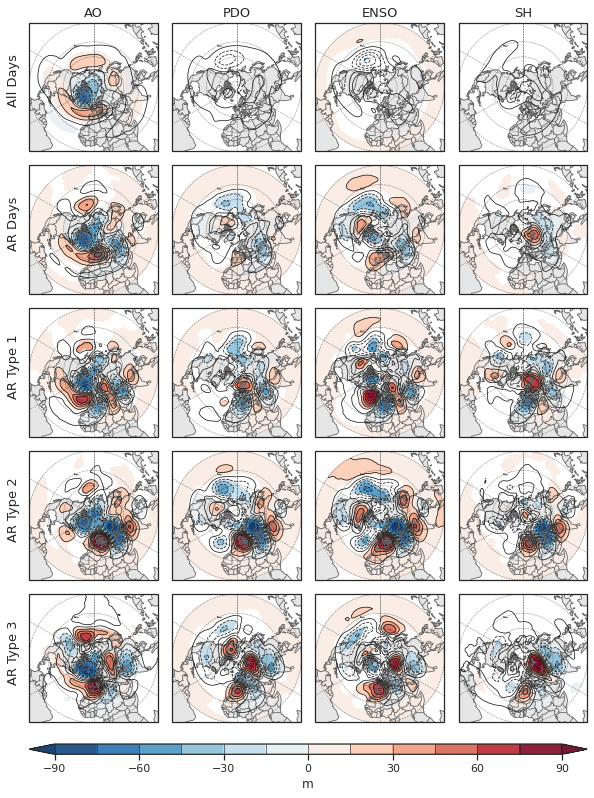

In [23]:
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'
filepath = fig_path + 'composite_teleconnection.png'    
nrows = 5
ncols = 4

cols = ['AO', 'PDO', 'ENSO', 'SH']
plt_lbls = ['AO']+['']*4 + ['PDO']+['']*4 +['ENSO']+['']*4 + ['SH']+['']*4
row_lbl1 = ['All Days','AR Days','AR Type 1','AR Type 2', 'AR Type 3']+ ['']*15

# Create figure
fig = plt.figure(figsize=(10,15))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.2,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.10, cbar_size='2%',label_mode='',
                direction='column')

for k, ax in enumerate(axgr): 
    # data for plotting
    data = data_lst[k]
    tval_mask = tval_lst[k]
    
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values 
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], grid=True)
    
    # Contour Filled (mask==True) (only significant values)
    hgts_mask = data.where(tval_mask == True)
#     hgts = data
    cflevs = np.arange(-90, 95, 15)
    cf = ax.contourf(lons, lats, hgts_mask, transform=datacrs,
                     levels=cflevs, cmap='RdBu_r', alpha=0.9, extend='both')
    
#     # Contour (ALL)
#     hgts_mask = data.where(tval_mask == False)
#     cf_mask = ax.contourf(lons, lats, hgts_mask, transform=datacrs,
#                      levels=cflevs, cmap=cmap, alpha=0.25, extend='both')

    hgts = data
    clevs = np.arange(-60, 65, 15)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='k', linewidths=0.75)
#     plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5) 
    
    # plot titles
    ax.set_title(plt_lbls[k], fontsize=13)
    # Row labels
    ax.text(-0.07, 0.55, row_lbl1[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
                  
# # Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, spacing='uniform')
cb.set_label('m')
    
# Save figure
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()